### Практическое задание к уроку 6
**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

os.environ['MKL_NUM_THREADS'] = '1'

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [11]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (90504, 13) Users: 2375 Items: 5001
val_matcher
Shape: (168875, 12) Users: 2104 Items: 27584
train_ranker
Shape: (168875, 12) Users: 2104 Items: 27584
val_ranker
Shape: (117403, 12) Users: 1996 Items: 24270


# Grid search

In [12]:
from itertools import product

In [13]:
# N = Neighbors
N_PREDICT = 50 

In [14]:
weightings_list = ['bm25', 'tfidf']
model_type_list = ['als', 'bpr']
own_recommender_type_list = ['item-item', 'cosine', 'tfidf']
recs_type_list = ['own', 'rec', 'itm', 'usr']

In [15]:
result_dict = {
    'weighting': [],
    'model_type': [],
    'own_recommender_type': [],
    'own_recall': [],
    'rec_recall': [],
    'itm_recall': [],
    'usr_recall': []
}

In [ ]:
%%time
for weighting, model_type, own_recommender in product(
            weightings_list, model_type_list, own_recommender_type_list):
    recommender = MainRecommender(data_train_matcher, weighting=weighting,
                                 model_type=model_type, own_recommender_type=own_recommender)
    result_dict['weighting'].append(weighting)
    result_dict['model_type'].append(model_type)
    result_dict['own_recommender_type'].append(own_recommender)
    
    for el in recs_type_list:
        res = recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                        target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=N_PREDICT)
        result_dict[el + '_recall'].append(res)

In [17]:
result_df = pd.DataFrame(result_dict)
result_df

,weighting,model_type,own_recommender_type,own_recall,rec_recall,itm_recall,usr_recall
0,bm25,als,item-item,0.017500,0.009646,0.010043,0.002801
1,bm25,als,cosine,0.020191,0.009908,0.009539,0.002795
2,bm25,als,tfidf,0.020199,0.009728,0.009721,0.003004


In [18]:
for col in result_df.columns.to_list()[3:]:
    print(f'Best {col}:\n{result_df.loc[np.argmax(result_df[col]), :]}')
    print('*' * 30)

Best own_recall:
weighting                     bm25
model_type                     als
own_recommender_type         tfidf
own_recall               0.0201986
rec_recall              0.00972768
itm_recall               0.0097206
usr_recall              0.00300431
Name: 2, dtype: object
******************************
Best rec_recall:
weighting                     bm25
model_type                     als
own_recommender_type        cosine
own_recall               0.0201905
rec_recall              0.00990826
itm_recall              0.00953894
usr_recall              0.00279542
Name: 1, dtype: object
******************************
Best itm_recall:
weighting                     bm25
model_type                     als
own_recommender_type     item-item
own_recall               0.0174998
rec_recall              0.00964553
itm_recall               0.0100433
usr_recall              0.00280147
Name: 0, dtype: object
******************************
Best usr_recall:
weighting                     bm25


A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
**Наибольший recall@k показал метод get_own_recommendations=0.0207415  
Рекомендательная модель CosineRecommender(K=1). К матрице user_item_matrix применено взвешивание tf-idf**

# Init/train recommender

In [16]:
best_recommender = MainRecommender(data_train_matcher, weighting='tfidf',
                                 model_type='als', own_recommender_type='cosine')

### Recall@50 of matching

In [17]:
TOPK_RECALL = 50

In [21]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_RECALL)
    print(f'{el} recall: {res}')

own recall: 0.020741546016824826
rec recall: 0.01468850639543705
itm recall: 0.008841423452058675
usr recall: 0.006504727050402517


### Precision@5 of matching

In [18]:
TOPK_PRECISION = 5

In [23]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_matcher, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

own precision: 0.10941064638783209
rec precision: 0.05228136882129315
itm precision: 0.018441064638783273
usr precision: 0.023384030418251017


# Изменяю k

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [24]:
k_list = [20, 50, 100, 200, 500]

In [25]:
recall_k_dict = {
    'k': [],
    'own': [],
    'rec': [],
    'itm': [],
    'usr': []
}

In [26]:
for k in k_list:
    recall_k_dict['k'].append(k)
    print(f'k={k}\n')
    for el in recs_type_list:
        res = best_recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                        target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=k)
        recall_k_dict[el].append(res)
        print(f'{el} recall: {res}')
    print('*' * 40)

k=20

own recall: 0.015273882525977238
rec recall: 0.009526755174820474
itm recall: 0.003937990637872313
usr recall: 0.004238915130650045
****************************************
k=50

own recall: 0.020741546016824826
rec recall: 0.01468850639543705
itm recall: 0.008841423452058675
usr recall: 0.006504727050402517
****************************************
k=100

own recall: 0.024909421205892988
rec recall: 0.01995775462641018
itm recall: 0.013881886314806498
usr recall: 0.009146826673351842
****************************************
k=200

own recall: 0.030233680660563686
rec recall: 0.02694148580997766
itm recall: 0.02143777933063889
usr recall: 0.012591391604044655
****************************************
k=500

own recall: 0.04015130103918654
rec recall: 0.036975675789418204
itm recall: 0.03387760676361491
usr recall: 0.019524525557595554
****************************************


In [27]:
recall_k_df = pd.DataFrame(recall_k_dict)

In [28]:
recall_k_df

,k,own,rec,itm,usr
0,20,0.015274,0.009527,0.003938,0.004239
1,50,0.020742,0.014689,0.008841,0.006505
2,100,0.024909,0.019958,0.013882,0.009147
3,200,0.030234,0.026941,0.021438,0.012591
4,500,0.040151,0.036976,0.033878,0.019525


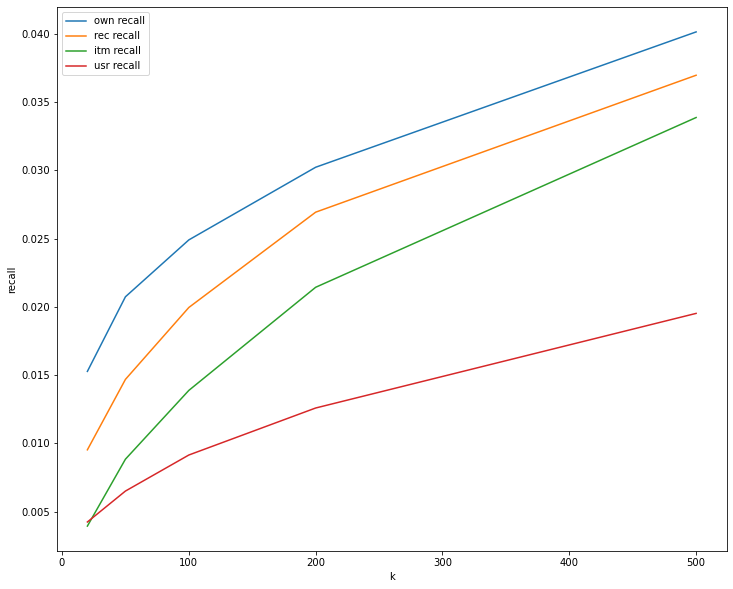

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

plt.plot(recall_k_df['k'], recall_k_df['own'], label='own recall')
plt.plot(recall_k_df['k'], recall_k_df['rec'], label='rec recall')
plt.plot(recall_k_df['k'], recall_k_df['itm'], label='itm recall')
plt.plot(recall_k_df['k'], recall_k_df['usr'], label='usr recall')

plt.xlabel('k')
plt.ylabel('recall')

plt.legend()
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?  

Однозначного ответа на данный вопрос дать нельзя. Выбор значения $k$ зависит от задачи, который стоит перед нами. При увеличении $k$ увеличивается $recall$, но при этом кратно увеличивается сложность вычисления.  
В данном случая, я думаю, $k$ нужно выбрать равным 100 или 200.

# Ranking part

## Подготовка данных для трейна

In [19]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [20]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: best_recommender.get_own_recommendations(x, N=N_PREDICT))

In [21]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[12810391, 12263816, 12988031, 1118963, 130728..."
1,2021,"[9245106, 895166, 909973, 12731685, 951761, 84..."


In [22]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [23]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [24]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,12810391
0,2070,12263816
0,2070,12988031
0,2070,1118963


### Check warm start

In [25]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (105200, 2) Users: 2104 Items: 4881


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [26]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [27]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [28]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [29]:
df_ranker_train.target.value_counts()

0.0    98941
1.0     3205
Name: target, dtype: int64

In [30]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,12810391,1.0
1,2070,12263816,0.0


## Подготавливаем фичи для обучения модели

In [31]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [32]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [33]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

**Фичи user_id:**  
    - Средний чек  
    - Средняя сумма покупки 1 товара в каждой категории  
    - Кол-во покупок в каждой категории  
    - Частотность покупок раз/месяц  
    - Долю покупок в выходные  
    - Долю покупок утром/днем/вечером  

**Фичи item_id**:  
    - Кол-во покупок в неделю  
    - Среднее кол-во покупок 1 товара в категории в неделю  
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)  
    - Цена (Можно посчитать из retil_train.csv)  
    - Цена / Средняя цена товара в категории  
    
**Фичи пары user_id - item_id**  
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)  
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)  
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)  

### user_id
1. Средняя сумма покупки 1 товара в каждой категории

In [34]:
def get_mean_purchase_per_item_by_department(data_train_ranker, item_features):
    sales_value_by_department = data_train_ranker.merge(item_features, on='item_id', 
            how='left').groupby(by=['user_id', 'department'])['sales_value'].sum().reset_index()
    quantity_by_department = data_train_ranker.merge(item_features, on='item_id', 
            how='left').groupby(by=['user_id', 'department'])['quantity'].sum().reset_index()
    mean_purchase_by_department = sales_value_by_department.merge(quantity_by_department, 
                                                    on=['user_id', 'department'], how='left')
    mean_purchase_by_department.drop(0, axis=0, inplace=True)
    mean_purchase_by_department.reset_index(inplace=True)
    mean_purchase_by_department.drop('index', axis=1, inplace=True)
    mean_purchase_by_department['mean_purchase'] = \
            mean_purchase_by_department['sales_value'] / mean_purchase_by_department['quantity']
    return mean_purchase_by_department

In [35]:
mean_purchase_by_department= get_mean_purchase_per_item_by_department(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_purchase_by_department[['user_id', 
                        'department', 'mean_purchase']], on=['user_id', 'department'], how='left')
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871


2. Кол-во покупок в каждой категории

In [36]:
def get_num_purchases_per_department(data_train_ranker, item_features):
    num_purchases_by_department = data_train_ranker.merge(item_features, on='item_id', 
            how='left').groupby(by=['user_id', 'department'])['basket_id'].nunique().reset_index()
    num_purchases_by_department.rename(columns={'basket_id': 'num_purchases'}, inplace=True)
    num_purchases_by_department.drop(0, axis=0, inplace=True)
    num_purchases_by_department.reset_index(inplace=True)
    num_purchases_by_department.drop('index', axis=1, inplace=True)
    return num_purchases_by_department

In [37]:
num_purchases_by_department = get_num_purchases_per_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(num_purchases_by_department[['user_id', 'department', 
                                        'num_purchases']], on=['user_id', 'department'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0


3. Доля покупок утром/днем/вечером

In [38]:
def get_proportion_of_purchases_by_times_of_day(data_train_ranker):
    users_transactions = data_train_ranker[['user_id', 'trans_time']].drop_duplicates(
                        subset=['trans_time']).reset_index().drop('index', axis=1)
    users_list = users_transactions.user_id.unique().tolist()
    
    user_trans_dict = {
        'user_id': [],
        'morning_trans': [],
        'day_trans': [],
        'evening_trans': []
    }
    for user in users_list:
        num_trans = users_transactions.loc[users_transactions.user_id == user, 
                                           'trans_time'].count()
        morning_trans = users_transactions[(users_transactions.user_id == user) & 
                                           (users_transactions.trans_time <= 900)].trans_time.count()
        day_trans = users_transactions[(users_transactions.user_id == user) & 
                                       (users_transactions.trans_time > 900) & 
                                       (users_transactions.trans_time < 1800)].trans_time.count()
        evening_trans = users_transactions[(users_transactions.user_id == user) & 
                                           (users_transactions.trans_time >= 1800)].trans_time.count()
        user_trans_dict['user_id'].append(user)
        user_trans_dict['morning_trans'].append(morning_trans / num_trans)
        user_trans_dict['day_trans'].append(day_trans / num_trans)
        user_trans_dict['evening_trans'].append(evening_trans / num_trans)
        
    user_trans_df = pd.DataFrame(user_trans_dict)
    return user_trans_df

In [39]:
user_trans_df = get_proportion_of_purchases_by_times_of_day(data_train_ranker)
df_ranker_train = df_ranker_train.merge(user_trans_df, on='user_id', how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25


### item_id
1. Кол-во покупок в неделю

In [40]:
def get_num_purchses_per_week(data_train_ranker):
    num_purchases_by_week = data_train_ranker.groupby(by=['item_id', 
                                        'week_no'])['basket_id'].nunique().reset_index()
    num_purchases_by_week.rename(columns={'basket_id': 'week_num_purchases'}, inplace=True)
    week_purchases_df = num_purchases_by_week.groupby(by='item_id').agg({'week_no': 'count', 
                                                 'week_num_purchases': 'sum'}).reset_index()
    week_purchases_df['n_purchases_per_week'] = \
                week_purchases_df.week_num_purchases / week_purchases_df.week_no
    return week_purchases_df

In [41]:
week_purchases_df = get_num_purchses_per_week(data_train_ranker)
df_ranker_train = df_ranker_train.merge(week_purchases_df[['item_id', 'n_purchases_per_week']], 
                                        on=['item_id'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0


2. Среднее кол-во покупок 1 товара в категории в неделю

In [42]:
def get_mean_num_purchases_per_item_dept_week(data_train_ranker, item_features):
    n_purhases_by_dept = data_train_ranker.merge(item_features, on='item_id', how='left').groupby(
        by=['department', 'week_no', 'item_id'])['basket_id'].nunique().reset_index()
    n_purhases_by_dept.rename(columns={'basket_id': 'n_purchases'}, inplace=True)
    n_items_per_week = n_purhases_by_dept.groupby(by=['department', 'week_no'])[
        'item_id'].count().reset_index()
    n_items_per_week.rename(columns={'item_id': 'n_items'}, inplace=True)
    n_purchases_per_week = n_purhases_by_dept.groupby(by=['department', 'week_no'])[
        'n_purchases'].sum().reset_index()
    mean_purchases_per_week = n_items_per_week.merge(n_purchases_per_week, 
                                                     on=['department', 'week_no'], how='left')
    mean_purchases_per_week['mean_purchases_per_week'] = round(
        mean_purchases_per_week.n_purchases / mean_purchases_per_week.n_items, 4)
    mean_purchases_per_week.drop([0, 1, 2, 3, 4, 5], axis=0, inplace=True)
    mean_purchases_per_week.reset_index(inplace=True)
    mean_purchases_per_week.drop('index', axis=1, inplace=True)
    
    mean_n_purchases_per_week = mean_purchases_per_week.groupby(by='department').agg({
        'week_no': 'count', 'mean_purchases_per_week': 'sum'}).reset_index()
    mean_n_purchases_per_week['mean_n_purchases_per_week'] = \
        mean_n_purchases_per_week.mean_purchases_per_week / mean_n_purchases_per_week.week_no
    return mean_n_purchases_per_week

In [43]:
mean_n_purchases_per_week = get_mean_num_purchases_per_item_dept_week(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_n_purchases_per_week[['department', 
                                        'mean_n_purchases_per_week']], on=['department'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817


3. (Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)

In [44]:
df_ranker_train['n_purchases_div_by_mean'] = \
    df_ranker_train.n_purchases_per_week / df_ranker_train.mean_n_purchases_per_week
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193


4. Цена

In [45]:
def get_price(data_train_ranker):
    item_price_df = data_train_ranker[['item_id', 'quantity', 'sales_value', 'retail_disc']].copy()
    item_price_df['price'] = (item_price_df.sales_value - 
                              item_price_df.retail_disc) / item_price_df.quantity
    item_price_df = item_price_df.groupby(by=['item_id'])['price'].mean().reset_index()
    return item_price_df

In [46]:
item_price_df = get_price(data_train_ranker)
df_ranker_train = df_ranker_train.merge(item_price_df[['item_id', 'price']], 
                                        on=['item_id'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150,35.512222
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193,4.990000


Цена / Средняя цена товара в категории

In [47]:
def get_mean_price_by_department(df_ranker_train):
    mean_price_by_department = df_ranker_train[['department', 
                            'price']].groupby('department')['price'].mean().reset_index()
    mean_price_by_department.rename(columns={'price': 'mean_price'}, inplace=True)
    return mean_price_by_department

In [48]:
df_ranker_train[['department', 'price']].loc[(df_ranker_train.department == 'PRODUCE') &
                                             (df_ranker_train.price > 7), 'price']

5242     inf
9688     inf
10929    inf
12522    inf
16494    inf
19001    inf
22194    inf
25902    inf
28700    inf
28983    inf
32640    inf
39029    inf
47515    inf
59686    inf
59791    inf
60543    inf
63962    inf
66764    inf
67632    inf
73942    inf
78085    inf
99229    inf
Name: price, dtype: float64

In [49]:
df_ranker_train.loc[(df_ranker_train.department == 'PRODUCE') &
                    (df_ranker_train.price > 7), 'price'] = 0

In [50]:
mean_price_by_department = get_mean_price_by_department(df_ranker_train)
df_ranker_train = df_ranker_train.merge(mean_price_by_department[['department', 'mean_price']], 
                                        on=['department'], how='left')
df_ranker_train['price_div_by_mean_dept_price'] = df_ranker_train.price / df_ranker_train.mean_price
df_ranker_train.drop('mean_price', axis=1, inplace=True)
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150,35.512222,4.184842
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193,4.990000,0.864230


### user_id - item_id
1. (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [51]:
def get_user_nun_purchases_per_week(data_train_ranker, item_features):
    purchases_by_usr = data_train_ranker.merge(item_features, on='item_id', how='left'
            ).groupby(by=['user_id', 'department', 'week_no'])['basket_id'].nunique().reset_index()
    usr_purchases_by_dept = purchases_by_usr.groupby(by=['user_id', 'department']).agg({
                                            'week_no': 'count', 'basket_id': 'sum'}).reset_index()
    usr_purchases_by_dept.rename(columns={'week_no': 'n_weeks', 
                                          'basket_id': 'n_purchases'}, inplace=True)
    usr_purchases_by_dept.drop(0, axis=0, inplace=True)
    usr_purchases_by_dept.reset_index(inplace=True)
    usr_purchases_by_dept.drop('index', axis=1, inplace=True)
    usr_purchases_by_dept['usr_purchases_by_dept_per_week'] = \
            usr_purchases_by_dept.n_purchases / usr_purchases_by_dept.n_weeks
    return usr_purchases_by_dept

In [52]:
def get_mean_purchases_all_users_by_department_per_week(data_train_ranker, item_features):
    all_users_purchases = data_train_ranker.merge(item_features, on='item_id', how='left'
            ).groupby(by=['department', 'week_no', 'user_id'])['basket_id'].nunique().reset_index()
    all_users_purchases_by_dept = all_users_purchases.groupby(by='department').agg({
                           'week_no': 'nunique', 'user_id': 'count', 'basket_id': 'sum'}).reset_index()
    all_users_purchases_by_dept.rename(columns={'user_id': 'n_users', 'week_no': 'n_weeks', 
                                                'basket_id': 'n_purchases'}, inplace=True)
    all_users_purchases_by_dept.drop(0, axis=0, inplace=True)
    all_users_purchases_by_dept.reset_index(inplace=True)
    all_users_purchases_by_dept.drop('index', axis=1, inplace=True)
    all_users_purchases_by_dept['mean_purchses_all_usrs_per_week'] = \
        all_users_purchases_by_dept.n_purchases / all_users_purchases_by_dept.n_users \
        / all_users_purchases_by_dept.n_weeks
    return all_users_purchases_by_dept

In [53]:
def get_num_purchases_sub_by_mean(data_train_ranker, item_features):
    usr_purchases_by_dept = get_user_nun_purchases_per_week(data_train_ranker, item_features)
    all_users_purchases_by_dept = get_mean_purchases_all_users_by_department_per_week(
                                                            data_train_ranker, item_features)
    
    n_purchases_sub_by_mean = usr_purchases_by_dept[['user_id', 'department', 
        'usr_purchases_by_dept_per_week']].merge(all_users_purchases_by_dept[['department',
        'mean_purchses_all_usrs_per_week']], on='department', how='left')
    n_purchases_sub_by_mean['n_purchases_sub_by_mean'] = \
        n_purchases_sub_by_mean.usr_purchases_by_dept_per_week - \
        n_purchases_sub_by_mean.mean_purchses_all_usrs_per_week
    return n_purchases_sub_by_mean

In [54]:
n_purchases_sub_by_mean = get_num_purchases_sub_by_mean(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_sub_by_mean[['user_id', 'department',
        'n_purchases_sub_by_mean']], on=['user_id', 'department'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150,35.512222,4.184842,0.805063
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193,4.990000,0.864230,3.076336


2. (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)  

In [55]:
def get_num_purchases_div_by_mean_all_users(data_train_ranker, item_features):
    usr_purchases_by_dept = get_user_nun_purchases_per_week(data_train_ranker, item_features)
    all_users_purchases_by_dept = get_mean_purchases_all_users_by_department_per_week(
                                                            data_train_ranker, item_features)
    
    n_purchases_div_by_mean = usr_purchases_by_dept[['user_id', 'department', 
        'usr_purchases_by_dept_per_week']].merge(all_users_purchases_by_dept[['department',
        'mean_purchses_all_usrs_per_week']], on='department', how='left')
    n_purchases_div_by_mean['n_purchases_div_by_mean_all_users'] = \
        n_purchases_sub_by_mean.usr_purchases_by_dept_per_week / \
        n_purchases_sub_by_mean.mean_purchses_all_usrs_per_week
    return n_purchases_div_by_mean

In [56]:
n_purchases_div_by_mean = get_num_purchases_div_by_mean_all_users(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_div_by_mean[['user_id', 'department',
        'n_purchases_div_by_mean_all_users']], on=['user_id', 'department'], how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150,35.512222,4.184842,0.805063,5.129866
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193,4.990000,0.864230,3.076336,12.970310


(Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)

In [57]:
def get_mean_sales_value_per_item_by_department(data_train_ranker, item_features):
    sales_values_by_dept = data_train_ranker.merge(item_features, on='item_id', 
                how='left').groupby(by=['department']).agg({'item_id': 'count', 
                'sales_value': 'sum'}).reset_index()
    sales_values_by_dept.drop(0, axis=0, inplace=True)
    sales_values_by_dept.reset_index(inplace=True)
    sales_values_by_dept.drop('index', axis=1, inplace=True)
    sales_values_by_dept.rename(columns={'item_id': 'n_items', 'sales_value': 'sale_sum'}, 
                                inplace=True)
    sales_values_by_dept['mean_sale_sum_per_item'] = \
                    sales_values_by_dept.sale_sum / sales_values_by_dept.n_items
    return sales_values_by_dept

In [58]:
sales_values_by_dept = get_mean_sales_value_per_item_by_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(sales_values_by_dept[['department', 'mean_sale_sum_per_item']], 
                                        on=['department'], how='left')
df_ranker_train['mean_sale_sum_per_item_sub_price'] = \
    df_ranker_train.mean_sale_sum_per_item - df_ranker_train.price
df_ranker_train.drop('mean_sale_sum_per_item', axis=1, inplace=True)
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.0,3.306550,1.512150,35.512222,4.184842,0.805063,5.129866,-29.022349
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.0,1.498817,0.667193,4.990000,0.864230,3.076336,12.970310,-1.010376


### Разбиваю на X и y

In [59]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.184842,0.805063,5.129866,-29.022349
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864230,3.076336,12.970310,-1.010376
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.057049,6.191276,21.054379,-0.957486
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.470403,3.076336,12.970310,-4.510376
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.383806,3.076336,12.970310,-4.010376


In [60]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [61]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.184842,0.805063,5.129866,-29.022349
1,2070,12263816,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864230,3.076336,12.970310,-1.010376
2,2070,12988031,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.057049,6.191276,21.054379,-0.957486
3,2070,1118963,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.470403,3.076336,12.970310,-4.510376
4,2070,13072850,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.383806,3.076336,12.970310,-4.010376


In [62]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [63]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

In [64]:
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [65]:
df_ranker_predict = df_ranker_train.copy()

In [66]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [67]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price,proba_item_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.184842,0.805063,5.129866,-29.022349,0.036036
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864230,3.076336,12.970310,-1.010376,0.014885
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.057049,6.191276,21.054379,-0.957486,0.010854
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.470403,3.076336,12.970310,-4.510376,0.065521
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.383806,3.076336,12.970310,-4.010376,0.006451


# Evaluation on test dataset

In [68]:
print('Matcher\'s precision:')
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_matcher, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

Matcher's precision:
own precision: 0.10941064638783209
rec precision: 0.05332699619771901
itm precision: 0.017395437262357413
usr precision: 0.023003802281368876


In [69]:
print('Ranker\'s precision:')
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_ranker, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

Ranker's precision:
own precision: 0.08847695390781533
rec precision: 0.046292585170340975
itm precision: 0.014428857715430829
usr precision: 0.01973947895791584


## Eval re-ranked matched result on test dataset

In [70]:
best_recommender.reranked_metrics(metric_type='precision', df_result=data_val_ranker, 
                                  df_predict=df_ranker_predict, target_col_name=USER_COL, 
                                  recommend_model_type='own', N_PREDICT=TOPK_PRECISION)

0.09039787798408479

При использовании двухуровневой модели precision@5 вырос примерно на 2%

## Увеличу значение $k$ на первом этапе

#### 1. $k=100$
**Подготавливаю данные**

In [71]:
N_PREDICT = 100

In [72]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [73]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: best_recommender.get_own_recommendations(x, N=N_PREDICT))

In [74]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [75]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [76]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [77]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_train['target'].fillna(0, inplace= True)

In [78]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

**Добавляю новые фичи**

In [79]:
# Средняя сумма покупки 1 товара в каждой категории
mean_purchase_by_department= get_mean_purchase_per_item_by_department(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_purchase_by_department[['user_id', 
                        'department', 'mean_purchase']], on=['user_id', 'department'], how='left')

# Кол-во покупок в каждой категории
num_purchases_by_department = get_num_purchases_per_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(num_purchases_by_department[['user_id', 'department', 
                                        'num_purchases']], on=['user_id', 'department'], how='left')

# Доля покупок утром/днем/вечером
user_trans_df = get_proportion_of_purchases_by_times_of_day(data_train_ranker)
df_ranker_train = df_ranker_train.merge(user_trans_df, on='user_id', how='left')

# Кол-во покупок в неделю
week_purchases_df = get_num_purchses_per_week(data_train_ranker)
df_ranker_train = df_ranker_train.merge(week_purchases_df[['item_id', 'n_purchases_per_week']], 
                                        on=['item_id'], how='left')

# Среднее кол-во покупок 1 товара в категории в неделю
mean_n_purchases_per_week = get_mean_num_purchases_per_item_dept_week(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_n_purchases_per_week[['department', 
                                        'mean_n_purchases_per_week']], on=['department'], how='left')

# (Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)
df_ranker_train['n_purchases_div_by_mean'] = \
    df_ranker_train.n_purchases_per_week / df_ranker_train.mean_n_purchases_per_week

# Цена
item_price_df = get_price(data_train_ranker)
df_ranker_train = df_ranker_train.merge(item_price_df[['item_id', 'price']], 
                                        on=['item_id'], how='left')

# Цена / Средняя цена товара в категории
df_ranker_train.loc[(df_ranker_train.department == 'PRODUCE') &
                    (df_ranker_train.price > 7), 'price'] = 0
mean_price_by_department = get_mean_price_by_department(df_ranker_train)
df_ranker_train = df_ranker_train.merge(mean_price_by_department[['department', 'mean_price']], 
                                        on=['department'], how='left')
df_ranker_train['price_div_by_mean_dept_price'] = df_ranker_train.price / df_ranker_train.mean_price
df_ranker_train.drop('mean_price', axis=1, inplace=True)

# (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_sub_by_mean = get_num_purchases_sub_by_mean(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_sub_by_mean[['user_id', 'department',
        'n_purchases_sub_by_mean']], on=['user_id', 'department'], how='left')

# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_div_by_mean = get_num_purchases_div_by_mean_all_users(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_div_by_mean[['user_id', 'department',
        'n_purchases_div_by_mean_all_users']], on=['user_id', 'department'], how='left')

# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
sales_values_by_dept = get_mean_sales_value_per_item_by_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(sales_values_by_dept[['department', 'mean_sale_sum_per_item']], 
                                        on=['department'], how='left')
df_ranker_train['mean_sale_sum_per_item_sub_price'] = \
    df_ranker_train.mean_sale_sum_per_item - df_ranker_train.price
df_ranker_train.drop('mean_sale_sum_per_item', axis=1, inplace=True)

**Разбиваю на X и y**

In [80]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.230870,0.805063,5.129866,-29.022349
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.059767,3.076336,12.970310,-1.010376
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.996251,6.191276,21.054379,-0.957486
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.803090,3.076336,12.970310,-4.510376
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.696901,3.076336,12.970310,-4.010376


In [81]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [82]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.230870,0.805063,5.129866,-29.022349
1,2070,12263816,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.059767,3.076336,12.970310,-1.010376
2,2070,12988031,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.996251,6.191276,21.054379,-0.957486
3,2070,1118963,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.803090,3.076336,12.970310,-4.510376
4,2070,13072850,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.696901,3.076336,12.970310,-4.010376


In [83]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

**Обучение модели ранжирования**

In [84]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

In [85]:
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [86]:
df_ranker_predict = df_ranker_train.copy()

In [87]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [88]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price,proba_item_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.230870,0.805063,5.129866,-29.022349,0.067581
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.059767,3.076336,12.970310,-1.010376,0.011242
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.996251,6.191276,21.054379,-0.957486,0.005563
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.803090,3.076336,12.970310,-4.510376,0.052819
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.696901,3.076336,12.970310,-4.010376,0.001625


**Evaluation on test dataset**

In [89]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_ranker, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

own precision: 0.08847695390781533
rec precision: 0.046292585170340975
itm precision: 0.014428857715430829
usr precision: 0.01973947895791584


**Eval re-ranked matched result on test dataset**

In [90]:
best_recommender.reranked_metrics(metric_type='precision', df_result=data_val_ranker, 
                                  df_predict=df_ranker_predict, target_col_name=USER_COL, 
                                  recommend_model_type='own', N_PREDICT=TOPK_PRECISION)

0.08594164456233425

#### 1. $k=200$
**Подготавливаю данные**

In [91]:
N_PREDICT = 200

In [92]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [93]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: best_recommender.get_own_recommendations(x, N=N_PREDICT))

In [94]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [95]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [96]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [97]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_train['target'].fillna(0, inplace= True)

In [98]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

**Добавляю новые фичи**

In [99]:
# Средняя сумма покупки 1 товара в каждой категории
mean_purchase_by_department= get_mean_purchase_per_item_by_department(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_purchase_by_department[['user_id', 
                        'department', 'mean_purchase']], on=['user_id', 'department'], how='left')

# Кол-во покупок в каждой категории
num_purchases_by_department = get_num_purchases_per_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(num_purchases_by_department[['user_id', 'department', 
                                        'num_purchases']], on=['user_id', 'department'], how='left')

# Доля покупок утром/днем/вечером
user_trans_df = get_proportion_of_purchases_by_times_of_day(data_train_ranker)
df_ranker_train = df_ranker_train.merge(user_trans_df, on='user_id', how='left')

# Кол-во покупок в неделю
week_purchases_df = get_num_purchses_per_week(data_train_ranker)
df_ranker_train = df_ranker_train.merge(week_purchases_df[['item_id', 'n_purchases_per_week']], 
                                        on=['item_id'], how='left')

# Среднее кол-во покупок 1 товара в категории в неделю
mean_n_purchases_per_week = get_mean_num_purchases_per_item_dept_week(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_n_purchases_per_week[['department', 
                                        'mean_n_purchases_per_week']], on=['department'], how='left')

# (Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)
df_ranker_train['n_purchases_div_by_mean'] = \
    df_ranker_train.n_purchases_per_week / df_ranker_train.mean_n_purchases_per_week

# Цена
item_price_df = get_price(data_train_ranker)
df_ranker_train = df_ranker_train.merge(item_price_df[['item_id', 'price']], 
                                        on=['item_id'], how='left')

# Цена / Средняя цена товара в категории
df_ranker_train.loc[(df_ranker_train.department == 'PRODUCE') &
                    (df_ranker_train.price > 7), 'price'] = 0
mean_price_by_department = get_mean_price_by_department(df_ranker_train)
df_ranker_train = df_ranker_train.merge(mean_price_by_department[['department', 'mean_price']], 
                                        on=['department'], how='left')
df_ranker_train['price_div_by_mean_dept_price'] = df_ranker_train.price / df_ranker_train.mean_price
df_ranker_train.drop('mean_price', axis=1, inplace=True)

# (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_sub_by_mean = get_num_purchases_sub_by_mean(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_sub_by_mean[['user_id', 'department',
        'n_purchases_sub_by_mean']], on=['user_id', 'department'], how='left')

# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_div_by_mean = get_num_purchases_div_by_mean_all_users(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_div_by_mean[['user_id', 'department',
        'n_purchases_div_by_mean_all_users']], on=['user_id', 'department'], how='left')

# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
sales_values_by_dept = get_mean_sales_value_per_item_by_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(sales_values_by_dept[['department', 'mean_sale_sum_per_item']], 
                                        on=['department'], how='left')
df_ranker_train['mean_sale_sum_per_item_sub_price'] = \
    df_ranker_train.mean_sale_sum_per_item - df_ranker_train.price
df_ranker_train.drop('mean_sale_sum_per_item', axis=1, inplace=True)

**Разбиваю на X и y**

In [100]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.379735,0.805063,5.129866,-29.022349
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.138946,3.076336,12.970310,-1.010376
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.010090,6.191276,21.054379,-0.957486
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.937806,3.076336,12.970310,-4.510376
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.823683,3.076336,12.970310,-4.010376


In [101]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [102]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.379735,0.805063,5.129866,-29.022349
1,2070,12263816,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.138946,3.076336,12.970310,-1.010376
2,2070,12988031,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.010090,6.191276,21.054379,-0.957486
3,2070,1118963,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.937806,3.076336,12.970310,-4.510376
4,2070,13072850,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.823683,3.076336,12.970310,-4.010376


In [103]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

**Обучение модели ранжирования**

In [104]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

In [105]:
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [106]:
df_ranker_predict = df_ranker_train.copy()

In [107]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [108]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price,proba_item_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,4.379735,0.805063,5.129866,-29.022349,0.133603
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,1.138946,3.076336,12.970310,-1.010376,0.008678
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,1.010090,6.191276,21.054379,-0.957486,0.004745
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.937806,3.076336,12.970310,-4.510376,0.041365
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.823683,3.076336,12.970310,-4.010376,0.001215


**Evaluation on test dataset**

In [109]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_ranker, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

own precision: 0.08847695390781533
rec precision: 0.046292585170340975
itm precision: 0.014428857715430829
usr precision: 0.01973947895791584


**Eval re-ranked matched result on test dataset**

In [110]:
best_recommender.reranked_metrics(metric_type='precision', df_result=data_val_ranker, 
                                  df_predict=df_ranker_predict, target_col_name=USER_COL, 
                                  recommend_model_type='own', N_PREDICT=TOPK_PRECISION)

0.08021220159151216

### При учеличении $k$ на первом этапе, после ранжирования значение $precision@k$ снижается по сравнению с $k=50$: на 4.93% при $k=100$ и на 11.27% при $k=200$. Попробую наоборот уменьшить значение $k$.

#### 1. $k=20$
**Подготавливаю данные**

In [111]:
N_PREDICT = 20

In [112]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [113]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: best_recommender.get_own_recommendations(x, N=N_PREDICT))

In [114]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [115]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [116]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [117]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_train['target'].fillna(0, inplace= True)

In [118]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

**Добавляю новые фичи**

In [119]:
# Средняя сумма покупки 1 товара в каждой категории
mean_purchase_by_department= get_mean_purchase_per_item_by_department(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_purchase_by_department[['user_id', 
                        'department', 'mean_purchase']], on=['user_id', 'department'], how='left')

# Кол-во покупок в каждой категории
num_purchases_by_department = get_num_purchases_per_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(num_purchases_by_department[['user_id', 'department', 
                                        'num_purchases']], on=['user_id', 'department'], how='left')

# Доля покупок утром/днем/вечером
user_trans_df = get_proportion_of_purchases_by_times_of_day(data_train_ranker)
df_ranker_train = df_ranker_train.merge(user_trans_df, on='user_id', how='left')

# Кол-во покупок в неделю
week_purchases_df = get_num_purchses_per_week(data_train_ranker)
df_ranker_train = df_ranker_train.merge(week_purchases_df[['item_id', 'n_purchases_per_week']], 
                                        on=['item_id'], how='left')

# Среднее кол-во покупок 1 товара в категории в неделю
mean_n_purchases_per_week = get_mean_num_purchases_per_item_dept_week(data_train_ranker, 
                                                                      item_features)
df_ranker_train = df_ranker_train.merge(mean_n_purchases_per_week[['department', 
                                        'mean_n_purchases_per_week']], on=['department'], how='left')

# (Кол-во покупок в неделю) / (Среднее кол-во покупок 1 товара в категории в неделю)
df_ranker_train['n_purchases_div_by_mean'] = \
    df_ranker_train.n_purchases_per_week / df_ranker_train.mean_n_purchases_per_week

# Цена
item_price_df = get_price(data_train_ranker)
df_ranker_train = df_ranker_train.merge(item_price_df[['item_id', 'price']], 
                                        on=['item_id'], how='left')

# Цена / Средняя цена товара в категории
df_ranker_train.loc[(df_ranker_train.department == 'PRODUCE') &
                    (df_ranker_train.price > 7), 'price'] = 0
mean_price_by_department = get_mean_price_by_department(df_ranker_train)
df_ranker_train = df_ranker_train.merge(mean_price_by_department[['department', 'mean_price']], 
                                        on=['department'], how='left')
df_ranker_train['price_div_by_mean_dept_price'] = df_ranker_train.price / df_ranker_train.mean_price
df_ranker_train.drop('mean_price', axis=1, inplace=True)

# (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_sub_by_mean = get_num_purchases_sub_by_mean(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_sub_by_mean[['user_id', 'department',
        'n_purchases_sub_by_mean']], on=['user_id', 'department'], how='left')

# (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
n_purchases_div_by_mean = get_num_purchases_div_by_mean_all_users(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(n_purchases_div_by_mean[['user_id', 'department',
        'n_purchases_div_by_mean_all_users']], on=['user_id', 'department'], how='left')

# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
sales_values_by_dept = get_mean_sales_value_per_item_by_department(data_train_ranker, item_features)
df_ranker_train = df_ranker_train.merge(sales_values_by_dept[['department', 'mean_sale_sum_per_item']], 
                                        on=['department'], how='left')
df_ranker_train['mean_sale_sum_per_item_sub_price'] = \
    df_ranker_train.mean_sale_sum_per_item - df_ranker_train.price
df_ranker_train.drop('mean_sale_sum_per_item', axis=1, inplace=True)

**Разбиваю на X и y**

In [120]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,3.842226,0.805063,5.129866,-29.022349
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864854,3.076336,12.970310,-1.010376
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.987507,6.191276,21.054379,-0.957486
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.471465,3.076336,12.970310,-4.510376
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.384806,3.076336,12.970310,-4.010376


In [121]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [122]:
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price
0,2070,12810391,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,3.842226,0.805063,5.129866,-29.022349
1,2070,12263816,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864854,3.076336,12.970310,-1.010376
2,2070,12988031,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.987507,6.191276,21.054379,-0.957486
3,2070,1118963,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.471465,3.076336,12.970310,-4.510376
4,2070,13072850,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.384806,3.076336,12.970310,-4.010376


In [123]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

**Обучение модели ранжирования**

In [124]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

In [125]:
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [126]:
df_ranker_predict = df_ranker_train.copy()

In [127]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [128]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases,morning_trans,day_trans,evening_trans,n_purchases_per_week,mean_n_purchases_per_week,n_purchases_div_by_mean,price,price_div_by_mean_dept_price,n_purchases_sub_by_mean,n_purchases_div_by_mean_all_users,mean_sale_sum_per_item_sub_price,proba_item_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,9.684545,3.0,0.75,0.0,0.25,5.000000,3.306550,1.512150,35.512222,3.842226,0.805063,5.129866,-29.022349,0.087706
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,4.990000,0.864854,3.076336,12.970310,-1.010376,0.016559
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.461549,39.0,0.75,0.0,0.25,4.333333,2.493417,1.737910,3.490000,0.987507,6.191276,21.054379,-0.957486,0.026722
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.200000,1.498817,0.800632,8.490000,1.471465,3.076336,12.970310,-4.510376,0.100742
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.443871,20.0,0.75,0.0,0.25,1.000000,1.498817,0.667193,7.990000,1.384806,3.076336,12.970310,-4.010376,0.027832


**Evaluation on test dataset**

In [129]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_ranker, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

own precision: 0.08847695390781533
rec precision: 0.046292585170340975
itm precision: 0.014428857715430829
usr precision: 0.01973947895791584


**Eval re-ranked matched result on test dataset**

In [130]:
best_recommender.reranked_metrics(metric_type='precision', df_result=data_val_ranker, 
                                  df_predict=df_ranker_predict, target_col_name=USER_COL, 
                                  recommend_model_type='own', N_PREDICT=TOPK_PRECISION)

0.09655172413793074

#### При $k=20$ значение $precision@k$ возросло на 6.8% по сравнению с $k=50$.

##### Возвращаясь к впросу 1 C)* могу сделать вывод, что на основе полученных данных для модели ранжирования лучше брать небольшоше значение $k$. В данном случае наилучший результат показала двухуровневая модель с $k=20$.